In [1]:
import time
import os
import cv2

from lib.file.TIF import *
from lib.analysis.ROI_identification import *
from lib.file.ROI_writer import ROIFileWriter
from lib.file.ROI_reader import ROIFileReader
from lib.file.TSV import RegionExporter
from lib.analysis.align import ImageAlign
from lib.file.DAT import TracesDAT
from lib.trace import Tracer
from lib.utilities import *
from lib.analysis.laminar_dist import *

slice 7 , rec 1
laminar axis unit vectors: [-0.9997918184634463, -0.020403914662519312] [-0.9978801059658183, -0.06507913734559685]
ROI centers: [[17.27, 49.71], [29.2, 48.69], [25.3, 48.54], [21.52, 49.37], [17.7, 49.6], [13.8, 49.42], [10.03, 49.9], [6.12, 49.78], [2.29, 49.86]]
Stim point: [36, 57]
laminar_distances: [18.87, 6.97, 10.87, 14.63, 18.45, 22.35, 26.11, 30.02, 33.85]
laminar_distances: [18.87, 6.97, 10.87, 14.63, 18.45, 22.35, 26.11, 30.02, 33.85]


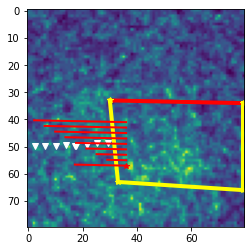

In [4]:
data_dir = "C:/Users/jjudge3/Desktop/Data/Kate's/ROI_dist/"
corners_file_prefix = 'corners'
electrode_file_prefix = 'electrode_calc_dist'
rois_file_prefix = 'rois' # e.g. 'rois_01_to_09.dat'
snr_file_prefix = 'SNR'

image_data = {}
n_plots = 5  # how many to show

for filename in os.listdir(data_dir):
    if filename.startswith("SNR"):
        suffix = filename[3:12]  # of the format -07_01_01
        name_parse = filename.split('.')[0][-8:]
        try:
            slic, loc, rec = [int(x) for x in name_parse.split('_')]
        except ValueError:
            continue
        if slic not in image_data:
            image_data[slic] = {}
        if loc not in image_data[slic]:
            image_data[slic][loc] = {}
        snr = np.loadtxt(data_dir + filename,
                         delimiter='\t',
                         usecols=(1,))
        width = int(np.sqrt(snr.shape[0]))
        snr = snr.reshape((width, width))
        
        print("slice", slic, ", rec", rec)
        
        # open corners, pick two points p1, p2 that define the edge along which to measure
        la_file = data_dir + corners_file_prefix + suffix + '.dat'
        lines = None
        with open(la_file, 'r') as f:
            lines = f.readlines() 
        corners = [int(x) for x in lines[4:]] # the last 4 lines are diode numbers of corners
        layer_axes = LayerAxes(corners)
        laminar_axis, laminar_axis_2 = layer_axes.get_layer_axes()
        columnar_axis, columnar_axis_2 = layer_axes.get_column_axes()
        print("laminar axis unit vectors:", laminar_axis.get_unit_vector(), laminar_axis_2.get_unit_vector())
        
        # open all rois as lists of diode numbers
        rois_file = data_dir + rois_file_prefix + suffix + '.dat'
        rois = ROIFileReader(rois_file).get_roi_list()
        rois = [LaminarROI(r, img_width=width) for r in rois]
        roi_centers = [r.get_center() for r in rois]
        roi_centers = [[round(r[0], 2), round(r[1], 2)] for r in roi_centers]
        print("ROI centers:", roi_centers)

        # open stim point roi as a single integer (its diode number) in variable stim_pt
        sp_file = data_dir + electrode_file_prefix + suffix + '.dat'
        with open(sp_file, 'r') as f:
            lines = f.readlines()
        stim_pt = int(lines[-1]) # last line is always electrode location
        aux_obj = LaminarROI([stim_pt]).get_points()
        stim_pt = aux_obj[0]  # should be a list of len 2, representing px location [x, y]
        print("Stim point:", stim_pt)

        # run laminar dist computation
        laminar_distances = LaminarDistance(laminar_axis, rois, stim_pt).compute_laminar_distances()
        laminar_distances = [round(ld, 2) for ld in laminar_distances]
        print('laminar_distances:', laminar_distances)  # a list of integers with same indexing as rois
        
        # run laminar dist again with the other axis
        laminar_distances_2 = LaminarDistance(laminar_axis_2, rois, stim_pt).compute_laminar_distances()
        laminar_distances_2 = [round(ld, 2) for ld in laminar_distances]
        print('laminar_distances:', laminar_distances)  # a list of integers with same indexing as rois
        
        image_data[slic][loc][rec] = {
            'snr': snr,
            'filename': filename,
            'laminar_distances': laminar_distances}
        
        # Now that the data is stored, show intermediate computations in plot
        if n_plots > 0:
            lines = [laminar_axis.get_line_repr(),
                     columnar_axis.get_line_repr(),
                     columnar_axis_2.get_line_repr(),
                     laminar_axis_2.get_line_repr()]
            line_colors = ['red', 'yellow', 'yellow', 'yellow']
            linewidths = [4,4,4,4]
            other_colors = ['red']
            
            # laminar aux lines
            uv = laminar_axis.get_unit_vector()
            for i in range(len(laminar_distances)):
                ld = laminar_distances[i]
                jiggle = i * 2
                stim_proxy_pt = [stim_pt[0], stim_pt[1] - jiggle]
                measure_vector = [uv[0] * ld + stim_proxy_pt[0], uv[1] * ld + stim_proxy_pt[1]]
                lines.append([measure_vector, stim_proxy_pt])
                line_colors.append(other_colors[i % len(other_colors)])
                linewidths.append(2)
                
            LaminarVisualization(snr, 
                                 stim_pt, 
                                 roi_centers, 
                                 layer_axes.get_corners(),
                                 lines,
                                 line_colors,
                                 linewidths)
            n_plots -= 1
